### Implementing a 3-SAT Verifier on a Quantum Circuit

In this coding activity, you will implement a verifier for a 3-SAT instance on a quantum circuit.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random, cmath
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, assemble, Aer
from qiskit.quantum_info import Statevector
from qiskit.visualization import array_to_latex, state_visualization
from qiskit.visualization import plot_bloch_multivector, plot_histogram, plot_state_city 
import qis401

### Part 1

To begin, write a function <code>or_gate(circ, a, b, result)</code> that takes in a QuantumCircuit <code>circ</code> and three single-qubit QuantumRegisters <code>a, b</code> and <code>result</code> as parameters. The function should add quantum gates to <code>circ</code> that collectively perform an OR operation on qubits <code>a</code> and <code>b</code>, which is then stored on the qubit <code>result</code>. Also <b>(important!)</b>, qubits <code>a</code> and <code>b</code> should be restored to their original values @return. 

Assume that the ancilla <code>result</code> qubit is in state $|1\rangle$ at the start of the function. As discussed in the previous lecture, you should implement NOT using an X gate (and therefore no additional ancilla registers need to be passed in). 

In [2]:
# YOUR CODE GOES HERE (DELETE THIS COMMENT)
def or_gate(circ, a, b, result):
    circ.x(a)
    circ.x(b)
    circ.ccx(a, b, result)
    circ.x(a)
    circ.x(b)

### Part 2

Next, write a function <code>add_clause(circ, vars_reg, clause, c_index, clause_ancilla, clause_outputs)</code> that adds a subcircuit to the QuantumCircuit <code>circ</code> that evaluates a single clause. For a 3-SAT instance with $n$ variables and $m$ clauses, the specifications for the remaining parameters are as follows:

* <code>vars_reg</code>: an $n$-qubit quantum register that throughout stores the values assigned to each Boolean variable. For example, if $x_1$ is to be <code>True</code> in the assignment, then <code>var_reg[0]</code> is in state $|1\rangle$ prior to calling the function.


* <code>clause</code>: a three-tuple that contains three positive or negative ints that indicate each of the 1-indexed literals in the clause, where negated values correspond to negative literals. For example, the clause $(x_1 \vee x_2 \vee \overline{x_3})$ would be represented by the tuple $(1, 2, -3)$. (This is actually a standard SAT solver encoding known as DIMACS notation.) 


* <code>c_index:</code> The index of the clause in the overall formula (0-indexed). 


* <code>clause_ancillas</code> and <code>clause_outputs</code>: both $m$-qubit registers, where <code>clause_ancillas[c_index]</code> is the ancilla qubit that will be used to store the the result of ORing the first two literals in the clause, and <code>clause_outputs[c_index]</code> should then store the overall evaluation of the clause @return.  

Note that like the <code>or_gate()</code> function from Part 1, the states of qubits in <code>var_reg</code> should be restored to their original value @return.

In [3]:
# YOUR CODE GOES HERE (DELETE THIS COMMENT)
def add_clause(circ, vars_reg, clause, c_index, clause_ancilla, clause_outputs):
    working_qubit = [abs(i)-1 for i in clause]
    flipped_qubit = []
    for i in range(len(clause)):
        if clause[i] < 0:
            circ.x(vars_reg[abs(clause[i])-1])
            flipped_qubit.append(-clause[i]-1)
    or_gate(circ, vars_reg[working_qubit[0]], vars_reg[working_qubit[1]], clause_ancilla[c_index])
    or_gate(circ, clause_ancilla[c_index], vars_reg[working_qubit[2]], clause_outputs[c_index])
    for i in flipped_qubit:
        circ.x(vars_reg[i])

### Part 3

Finally, now write a function <code>make_3sat_circuit(clauses, assignment)</code> that returns the overall quantum circuit that evaluates a 3-SAT formula for a given assignment.  In particular, <code>assignment</code> is a list of Booleans indicating how each (0-indexed) variable is set in the assignment. <code>clauses</code> is then a list of three tuples specifying each clause in DIMACS notation. 

A couple things to keep in mind:

* Recall that both functions in Part 1 and 2 assume the ancilla qubits have already been set to state $|1\rangle$ before calling the function. Therefore you will need to take care of this at this point in the solution. 


* To evaluate the overall formula (i.e., ANDing together the results if all clauses), you should use a <i>multi-CX</i> gate, which generalizes CX and Tofolli gates to an arbitrary number of control qubits. For example, we can create a multi-CX gate with three controls using the <code>mtc()</code> method as follows.

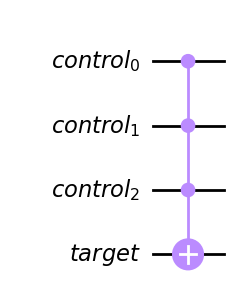

In [4]:
# multi-CX example
controls = QuantumRegister(3, "control")
target = QuantumRegister(1, "target")
circ = QuantumCircuit(controls, target)
circ.mct(controls, target)
circ.draw('mpl')

In [5]:
# YOUR CODE GOES HERE (DELETE THIS COMMENT)
def make_3sat_circuit(clauses, assignment):
    vars_reg = QuantumRegister(len(assignment), "vars_reg")
    clause_ancilla = QuantumRegister(len(clauses), "clause_ancilla")
    clause_outputs = QuantumRegister(len(clauses), "clauses_outputs")
    result = QuantumRegister(1, "result")
    circ = QuantumCircuit(vars_reg, clause_ancilla, clause_outputs, result)
    
    for i in range(len(assignment)):
        if assignment[i]:
            circ.x(vars_reg[i])
    circ.x(clause_ancilla)
    circ.x(clause_outputs)

    for i in range(len(clauses)):
        add_clause(circ, vars_reg, clauses[i], i, clause_ancilla, clause_outputs)

    circ.mct(clause_outputs, result)

    return circ

### Testing Your Solution

The cells below can be used to test your solution. 

In [6]:
def three_sat_test(clauses, assignment):
    ''' 
    Evaluates a 3-SAT instance in CNF with n variables and m clauses
    for a fixed assignment of the Boolean variables in the formula. 
    
    Args
        clauses: a list of 3-tuples specifying the formula in DIMACS notation
        assignment: a list of Booleans (assignment[0] = True -> x_1 = True)
    Returns: 
        True if the formulas evalutes to True; otherwise returns False. 
    '''
    circ = make_3sat_circuit(clauses, assignment)
    result = qis401.simulate_circuit(circ, 1)
    output = list(result.get_counts().keys())[0]
    return output[0] == '1'

In [7]:
clauses1 = [(1, 2, -3), (1, -3, -4)]   # instance (x1 or x2 or ~x3) and (x1 or ~x3 or ~x4)
clauses2 = [(1, 2, 3), (2, 3, 4), (-1, -2, -4)]
assignment1 = [True, True, False, False]
assignment2 = [False, False, False, True]
assignment3 = [False, False, True, True]
assignment4 = [False, True, True, True]

assert three_sat_test(clauses1, assignment1) == True
assert three_sat_test(clauses1, assignment2) == True
assert three_sat_test(clauses1, assignment3) == False 
assert three_sat_test(clauses1, assignment4) == False

assert three_sat_test(clauses2, assignment1) == True
assert three_sat_test(clauses2, assignment2) == False
assert three_sat_test(clauses2, assignment3) == True 
assert three_sat_test(clauses2, assignment4) == True

# ADD ADDITIONAL TESTS HERE

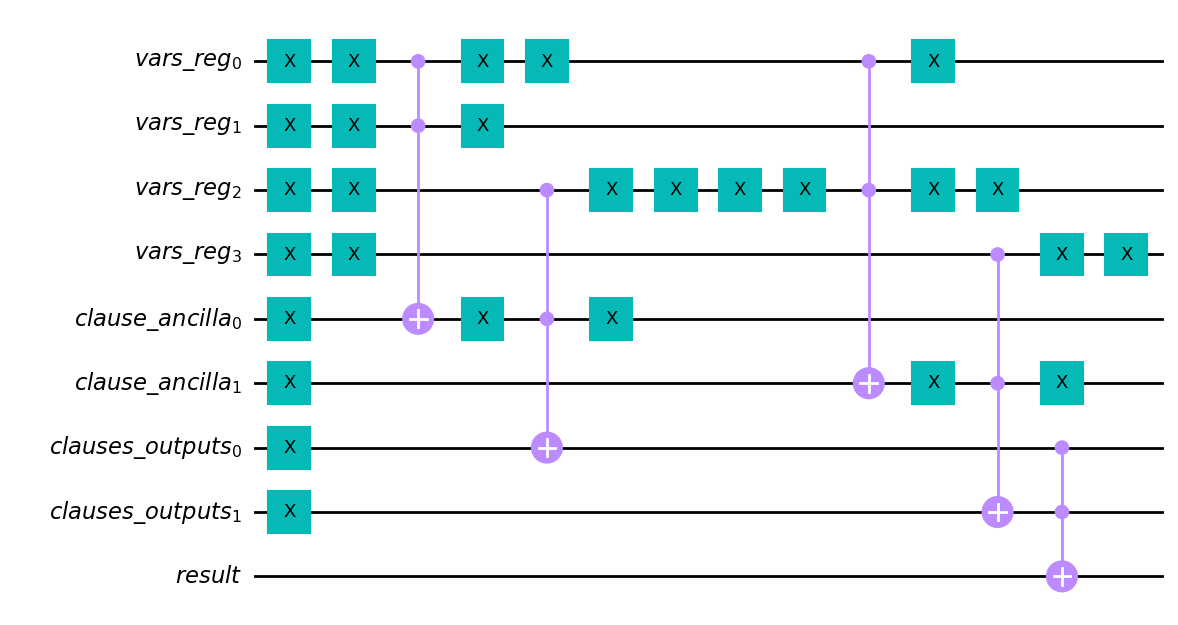

In [8]:
circ = make_3sat_circuit(clauses1, assignment1)
circ.draw("mpl")